In [1]:
from k1lib.imports import *

In [2]:
class SkipBlock(nn.Module):
    def __init__(self, hiddenDim=10):
        super().__init__()
        def gen(): return nn.Linear(hiddenDim, hiddenDim), nn.LeakyReLU()
        self.seq = nn.Sequential(*gen(), *gen(), *gen())
    def forward(self, x):
        return self.seq(x) + x

In [3]:
class Network(nn.Module):
    def __init__(self, hiddenDim=10, blocks=2, block=SkipBlock):
        super().__init__()
        layers = []
        layers += [nn.Linear(1, hiddenDim), nn.LeakyReLU()]
        for i in range(blocks): layers += [block(hiddenDim)]
        layers += [nn.Linear(hiddenDim, 1)]
        self.bulk = nn.Sequential(*layers)
    def forward(self, x):
        return self.bulk(x)

In [4]:
def newL(bs=64, optF=None, *args, **kwargs):
    if optF == None: optF = lambda x: optim.SGD(x, lr=2e-4, momentum=0.9)
    if optF == "Adam": optF = lambda p: optim.Adam(p, lr=1e-2)
    l = k1lib.Learner()
    l.model = Network(*args, **kwargs)
    l.data = k1lib.data.Data.fromDataset(k1lib.data.FunctionDataset.exp, bs)
    l.opt = optF(l.model.parameters())
    l.lossF = lambda x, y: ((x.squeeze() - y)**2).mean()
    l.cbs.withModifyBatch(lambda x, y: (x[:, None], y))
    l.cbs.withDType(torch.float32);
    def evaluate(self):
        xbs, ybs, ys = self.record(1, 3)
        xbs = torch.vstack(xbs).squeeze()
        ybs = torch.vstack([yb[:, None] for yb in ybs]).squeeze()
        ys = torch.vstack(ys).squeeze()
        #plt.plot(xbs, ybs, ".")
        plt.plot(xbs, ys.detach(), ".")
    l.evaluate = partial(evaluate, l)
    l.cbs.withCancelOnLowLoss(1, epochMode=True)
    return l

In [5]:
ts1 = []
for blocks in range(30):
    l = newL(blocks=blocks)
    l.cbs = k1lib.Callbacks().withProgressBar().withModifyBatch(lambda x, y: (x[:, None], y)).withDType(torch.float32)
    l.run(1)
    ts1.append(l.ProgressBar.elapsedTime)

Progress:  95%, epoch: 0/1, batch: 149/157, elapsed:   1.47s  

In [6]:
ts2 = []
for blocks in range(30):
    l = newL(blocks=blocks)
    l.css = "SkipBlock: HookModule\nSkipBlock #0: HookParam"
    l.remove("Autosave")
    l.run(1)
    ts2.append(l.ProgressBar.elapsedTime)

Progress:  95%, epoch: 0/1, batch: 149/157, elapsed:   2.96s  

In [7]:
ts3 = []
for blocks in range(30):
    l = newL(blocks=blocks)
    l.remove("Autosave")
    l.run(1)
    ts3.append(l.ProgressBar.elapsedTime)

Progress:  95%, epoch: 0/1, batch: 149/157, elapsed:   5.71s  

In [8]:
with open("ts1.pth", "wb") as f: pickle.dump(ts1, f)
with open("ts2.pth", "wb") as f: pickle.dump(ts2, f)
with open("ts3.pth", "wb") as f: pickle.dump(ts3, f)

### Extras

In [9]:
ts4 = []
for blocks in range(30):
    l = newL(blocks=blocks)
    l.css = "SkipBlock: HookModule"
    l.remove("Autosave")
    l.run(1)
    ts4.append(l.ProgressBar.elapsedTime)

Progress:  95%, epoch: 0/1, batch: 149/157, elapsed:   2.74s  

In [10]:
ts5 = []
for blocks in range(30):
    l = newL(blocks=blocks)
    l.css = "SkipBlock #0: HookParam"
    l.remove("Autosave")
    l.run(1)
    ts5.append(l.ProgressBar.elapsedTime)

Progress:  95%, epoch: 0/1, batch: 149/157, elapsed:   2.53s  

In [11]:
ts6 = []
for blocks in range(30):
    l = newL(blocks=blocks)
    l.css = "none"
    l.remove("Autosave")
    l.run(1)
    ts6.append(l.ProgressBar.elapsedTime)

Progress:  95%, epoch: 0/1, batch: 149/157, elapsed:   2.29s  

In [12]:
with open("ts4.pth", "wb") as f: pickle.dump(ts4, f)
with open("ts5.pth", "wb") as f: pickle.dump(ts5, f)
with open("ts6.pth", "wb") as f: pickle.dump(ts6, f)

## Analysis

In [13]:
l = newL(blocks=3)
l.css = "SkipBlock: HookModule\nSkipBlock #0: HookParam"
l.moduleSelector

ModuleSelector:
root: Network                     
    bulk: Sequential                     
        0: Linear                         
        1: LeakyReLU                         
        2: SkipBlock                     HookModule
            seq: Sequential                     
                0: Linear                     HookParam    
                1: LeakyReLU                         
                2: Linear                         
                3: LeakyReLU                         
                4: Linear                         
                5: LeakyReLU                         
        3: SkipBlock                     HookModule
            seq: Sequential                     
                0: Linear                     HookParam    
                1: LeakyReLU                         
                2: Linear                         
                3: LeakyReLU                         
                4: Linear                         
                5: Lea

In [14]:
with open("ts1.pth", "rb") as f: ts1 = pickle.load(f)
with open("ts2.pth", "rb") as f: ts2 = pickle.load(f)
with open("ts3.pth", "rb") as f: ts3 = pickle.load(f)
with open("ts4.pth", "rb") as f: ts4 = pickle.load(f)
with open("ts5.pth", "rb") as f: ts5 = pickle.load(f)
with open("ts6.pth", "rb") as f: ts6 = pickle.load(f)

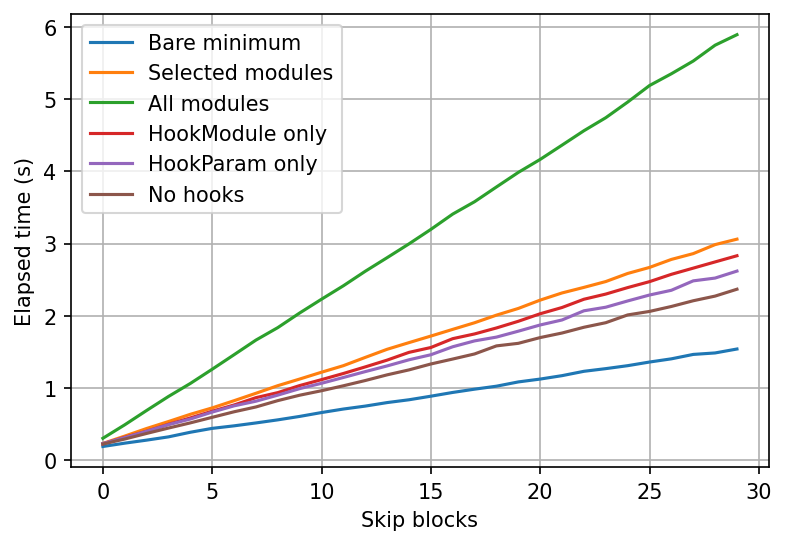

In [15]:
plt.figure(dpi=150); plt.xlabel("Skip blocks"); plt.ylabel("Elapsed time (s)"); plt.grid()
plt.plot(ts1); plt.plot(ts2); plt.plot(ts3); plt.plot(ts4); plt.plot(ts5); plt.plot(ts6)
plt.legend(["Bare minimum", "Selected modules", "All modules", "HookModule only", "HookParam only", "No hooks"]);

In [ ]:
plt.figure(dpi=150); plt.xlabel("Skip blocks"); plt.ylabel("Elapsed time (s)"); plt.grid()
plt.plot(ts1); plt.plot(ts2); plt.plot(ts3); plt.plot(ts4); plt.plot(ts5); plt.plot(ts6)
plt.legend(["Bare minimum", "Selected modules", "All modules", "HookModule only", "HookParam only", "No hooks"]);

Does this make sense?

- HookParam: selected 3/11
- HookModule: selected 3/29

So no, this doesn't make sense. Let's try doing only HookModule and HookParam
